In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
#%matplotlib qt


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)


# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()

print("done")

done


In [2]:
# A function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    img_size = (img.shape[1], img.shape[0])
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    #undist = np.copy(img)  # Delete this line
    return dst

print("done")

done


done


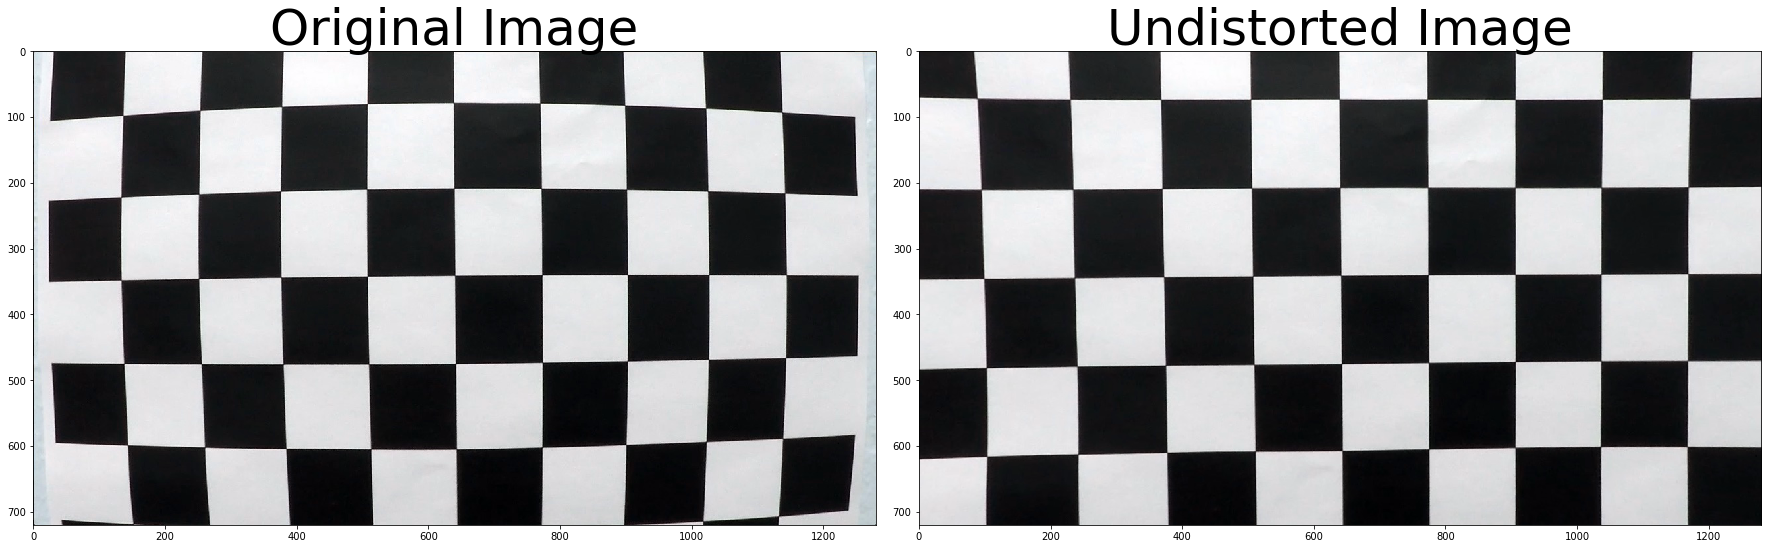

In [3]:
#unit test
#Read in an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0]) 

undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
print("done")

In [4]:
def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    
    return warped, M, Minv

print("done")


done


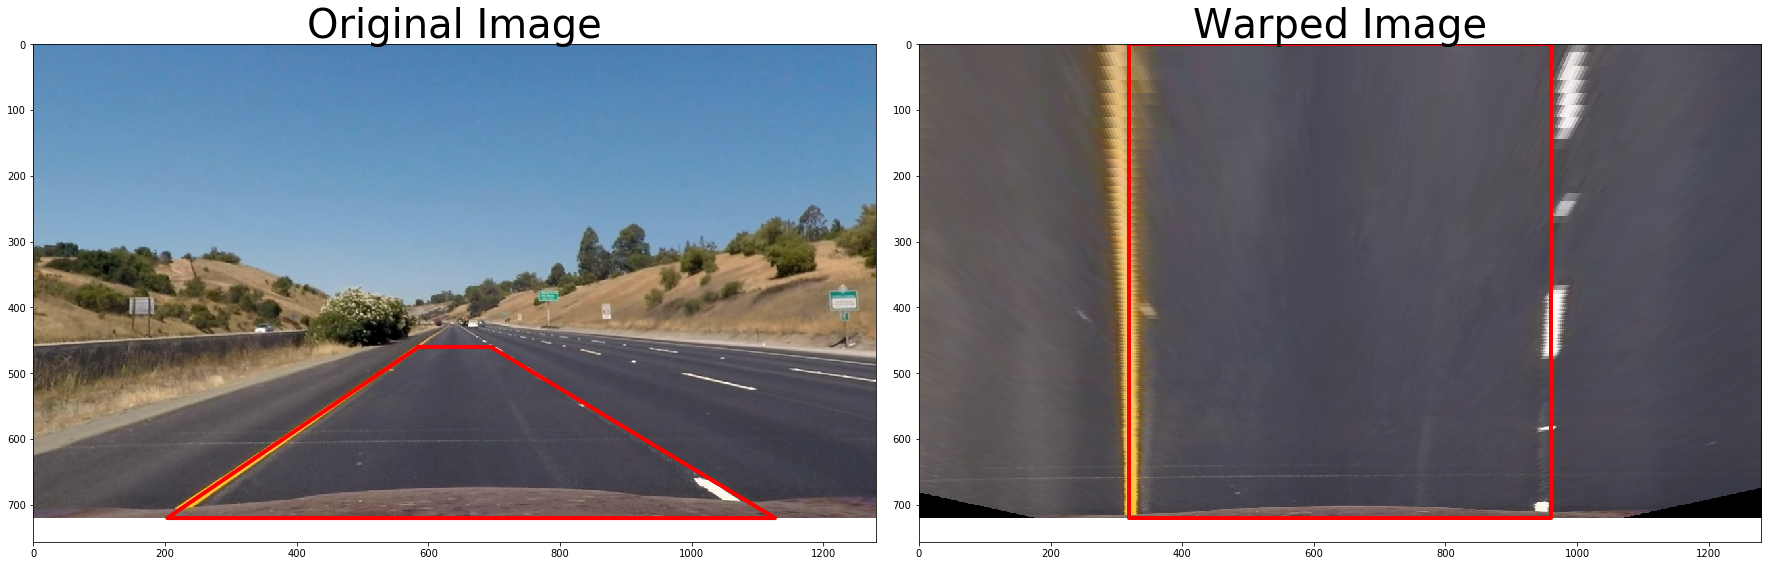

In [5]:
#unit test

img = mpimg.imread('test_images/straight_lines1.jpg')
img_size = (img.shape[1], img.shape[0])

src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

undistorted_img = cal_undistort(img, objpoints, imgpoints)
result, M, Minv= warper(undistorted_img, src, dst)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted_img)
ax1.set_title('Original Image', fontsize=40)
x = [src[0][0],src[1][0],src[2][0],src[3][0],src[0][0]]
y = [src[0][1],src[1][1],src[2][1],src[3][1],src[0][1]]
ax1.plot(x, y,'r-',lw=4)


ax2.imshow(result)
ax2.set_title('Warped Image', fontsize=40)
x = [dst[0][0],dst[1][0],dst[2][0],dst[3][0],dst[0][0]]
y = [dst[0][1],dst[1][1],dst[2][1],dst[3][1],dst[0][1]]
ax2.plot(x, y,'r-',lw=4)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [6]:
def gradient_threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

print("done")

done


Done


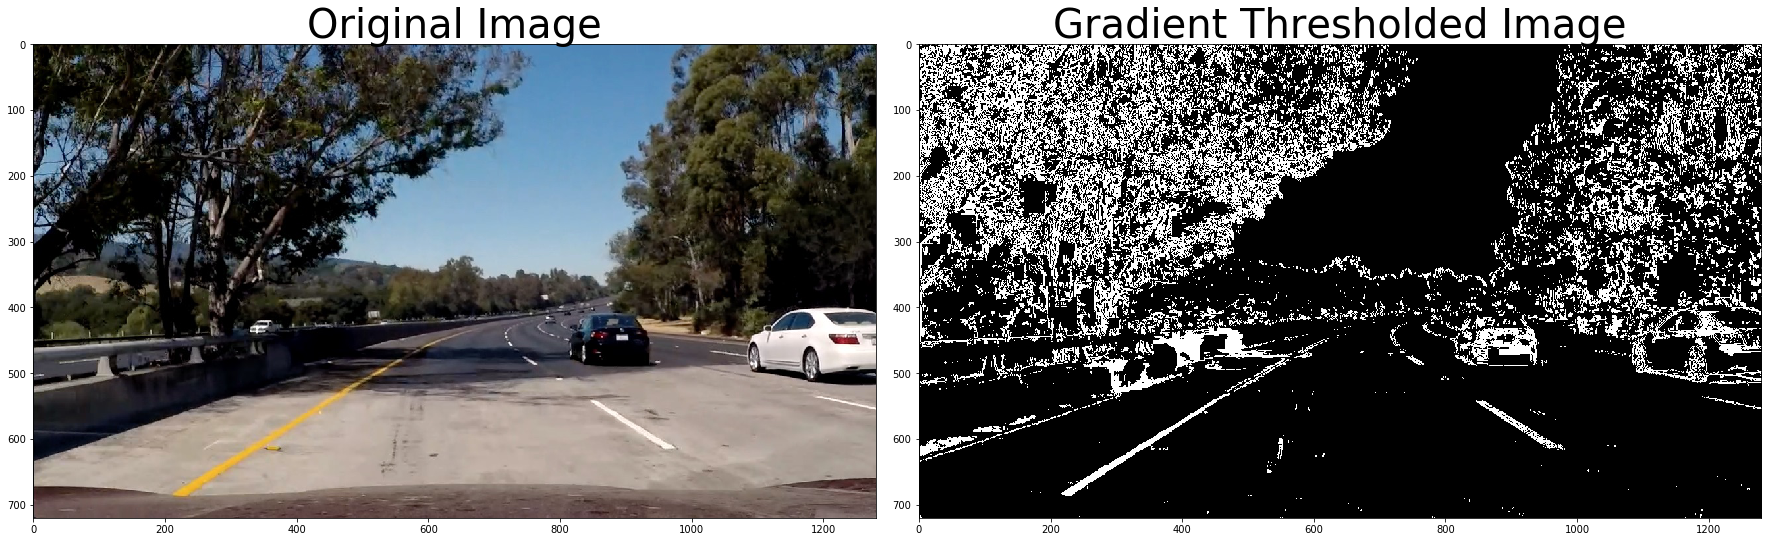

In [7]:
#unit test
img = cv2.imread('test_images/test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

result = gradient_threshold(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)


ax2.imshow(result, cmap='gray')
ax2.set_title('Gradient Thresholded Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

print("Done")

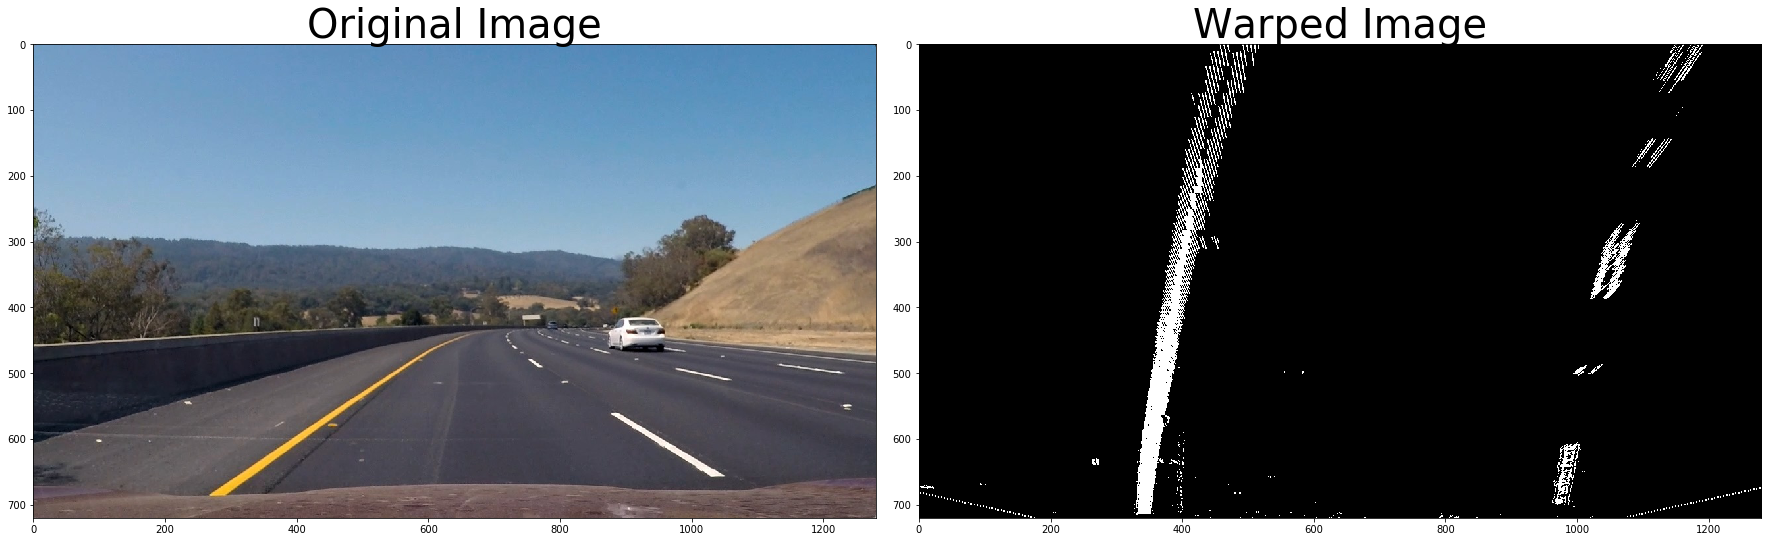

In [8]:
img = cv2.imread('test_images/test3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

undistorted_img = cal_undistort(img, objpoints, imgpoints)
warped_img, M, Minv = warper(undistorted_img, src, dst)
binary_warped = gradient_threshold(warped_img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)


ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

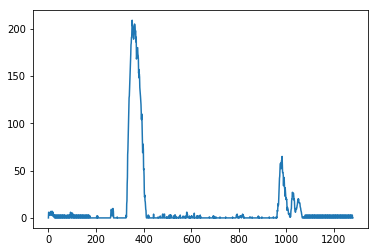

In [9]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [10]:
def polyfit_sliding_window(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 4) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 4) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, out_img
print("done")

done


(720, 0)

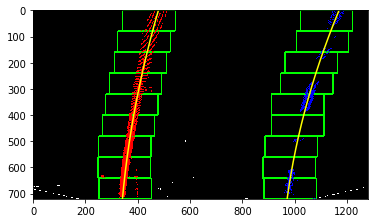

In [11]:
# Generate x and y values for plotting
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
left_fit, right_fit, left_lane_inds, right_lane_inds, out_img = polyfit_sliding_window(binary_warped)
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [12]:
margin = 100

def polyfit_previous_frame(warped_img, left_fit_prev, right_fit_prev):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    l_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    r_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    lx = nonzerox[l_lane_inds]
    ly = nonzeroy[l_lane_inds] 
    rx = nonzerox[r_lane_inds]
    ry = nonzeroy[r_lane_inds]
    # Fit a second order polynomial to each
    l_fit = np.polyfit(ly, lx, 2)
    r_fit = np.polyfit(ry, rx, 2)
#     # Generate x and y values for plotting
#     ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
#     l_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
#     r_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]
    
    return l_lane_inds, r_lane_inds, l_fit, r_fit

print("done")

done


(720, 0)

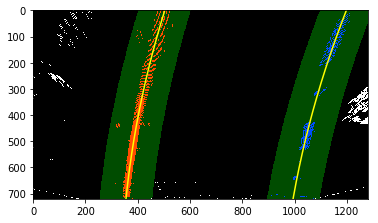

In [13]:
img2 = cv2.imread('test_images/test6.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

undistorted_img2 = cal_undistort(img2, objpoints, imgpoints)
warped_img2, M2, Minv2 = warper(undistorted_img2, src, dst)
binary_warped2 = gradient_threshold(warped_img2)

left_lane_inds2, right_lane_inds2, left_fit2, right_fit2 = polyfit_previous_frame(binary_warped2, left_fit, right_fit)

#Generate x and y values for plotting
ploty2 = np.linspace(0, binary_warped2.shape[0]-1, binary_warped2.shape[0] )
left_fitx2 = left_fit2[0]*ploty2**2 + left_fit2[1]*ploty2 + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty2**2 + right_fit2[1]*ploty2 + right_fit2[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped2, binary_warped2, binary_warped2))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
nonzero = binary_warped2.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx2-margin, ploty2]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx2+margin, ploty2])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx2-margin, ploty2]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx2+margin, ploty2])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx2, ploty2, color='yellow')
plt.plot(right_fitx2, ploty2, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)



In [14]:
def get_curverad_position(warped_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = warped_img.shape[0]
    ploty_t = np.linspace(0, h-1, h)
    y_eval = np.max(ploty_t)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    
    #print(l_lane_inds.shape)
    #print(r_lane_inds.shape)
    
    
    lx = nonzerox[l_lane_inds]
    ly = nonzeroy[l_lane_inds] 
    rx = nonzerox[r_lane_inds]
    ry = nonzeroy[r_lane_inds]

    if len(lx) != 0 and len(rx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ly*ym_per_pix, lx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ry*ym_per_pix, rx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters

    # car position = mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = warped_img.shape[1]/2
        lfitx = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        rfitx = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        car_position_lane_center = (lfitx + rfitx) /2
        center_dist = (car_position - car_position_lane_center) * xm_per_pix
        #print(left_curverad, right_curverad, center_dist)
        return left_curverad, right_curverad, center_dist
        
        
    
print("Done")


Done


In [15]:
lrad, rrad, cdist = get_curverad_position(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature :', lrad, 'm,', rrad, 'm')
print('Distance from lane center :', cdist, 'm')

Radius of curvature : 1183.39877939 m, 849.045592426 m
Distance from lane center : -0.087566737248 m


In [16]:
def draw_lane_information(warped_img,undist_img, l_fit, r_fit, l_lane_inds, r_lane_inds, M_inv):

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
    l_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    r_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([l_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([r_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    img_with_lane = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    
    lrad, rrad, cdist = get_curverad_position(warped_img, l_fit, r_fit, l_lane_inds, r_lane_inds)
    curve_radius = (lrad + rrad) / 2
    
    new_img = np.copy(img_with_lane)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Radius of curvature = ' + '{:04.2f}'.format(curve_radius) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if cdist > 0:
        direction = 'right'
    elif cdist < 0:
        direction = 'left'
    abs_cdist = abs(cdist)
    text = 'Vehicle is ' + '{:04.3f}'.format(abs_cdist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img
    
    #plt.imshow(result)

print("Done")

Done


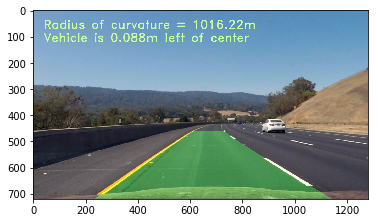

In [17]:
img_info = draw_lane_information(binary_warped,undistorted_img, left_fit, right_fit, left_lane_inds, right_lane_inds, Minv)
plt.imshow(img_info)

In [18]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.pixel_count = None
    def append_fit(self, fit, inds):
        # append a found fit to the line
        if fit is not None:
            if self.best_fit is not None:
                # compare with best fit
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # Not a good fit
                self.detected = False
            else:
                self.detected = True
                self.pixel_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # keep recent 5 and throw the old ones
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # remove oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # best_fit is average of remaining fits in the queue
                self.best_fit = np.average(self.current_fit, axis=0)


            

print("Done")

Done


In [19]:
def process_image(img):
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.copy(img)
    img_size = (image.shape[1], image.shape[0])

    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])

    undistorted_image = cal_undistort(image, objpoints, imgpoints)
    warped_image, M, Minv = warper(undistorted_image, src, dst)
    binary_warped = gradient_threshold(warped_image)
    
    # use polyfit_previous_frame if both left and right lines were detected in last frame else use sliding window
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, out_img = polyfit_sliding_window(binary_warped)
        #print("1")
    else:
        l_lane_inds, r_lane_inds, l_fit, r_fit = polyfit_previous_frame(binary_warped,  l_line.best_fit, r_line.best_fit)
        #l_fit, r_fit, l_lane_inds, r_lane_inds, out_img = polyfit_sliding_window(binary_warped3)
        #print("2")
        
    # Checking that they are separated by approximately the right distance horizontally
    if l_fit is not None and r_fit is not None:
        #print("3")
        h = image.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        #print(x_int_diff)
        if abs(700 - x_int_diff) > 100:
            #print("4")
            l_fit = None
            r_fit = None
            
    l_line.append_fit(l_fit, l_lane_inds)
    r_line.append_fit(r_fit, r_lane_inds)
    
    # use the best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        #print("5")
        img_out = draw_lane_information(binary_warped,undistorted_image, l_line.best_fit, r_line.best_fit, l_lane_inds, r_lane_inds, Minv)
    else:
        #print("6")
        img_out = image

    return img_out


    
print("done")

done


In [26]:
from moviepy.editor import VideoFileClip
l_line = Line()
r_line = Line()

video_output = 'project_video_output.mp4'
video_input = VideoFileClip('project_video.mp4')
processed_video = video_input.fl_image(process_image)
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [17:06<00:00,  1.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 16min 50s, sys: 1min 4s, total: 17min 54s
Wall time: 17min 7s
